In [15]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chi2_contingency, f_oneway

In [2]:
# project location
p_loc = 'C:/Users/joa24jm/Documents/tinnitus-country/'

# add src to path so the noteboook can import utilities.py
import sys
sys.path.append('C:\\Users\\joa24jm\\Documents\\tinnitus-country\\src\\')
from d00_utils import utilities as u

In [3]:
# read in dataframe for baseline users
proj_loc = 'C:/Users/joa24jm/Documents/tinnitus-country'

bl = pd.read_csv(proj_loc + '/data/02_intermediate/baseline.csv', index_col = 'Unnamed: 0',
                parse_dates = ['4', '9', 'created_at'],na_values = ['??.??.????', '27.02.2522']
                )

In [4]:
# convert column '4' (birthdate) and '9' (first time of tinnitus) to datetime objects
formats = '%d.%m.%Y'
bl.loc[:, '4'] = pd.to_datetime(bl['4'], errors = 'raise', format = formats)
bl.loc[:, '9'] = pd.to_datetime(bl['4'], errors = 'raise', format = formats)

In [5]:
# calculate the age by the time of filling out the questionnaire
bl['age'] = bl.created_at.dt.year - bl['4'].dt.year

In [6]:
# countries to compare baseline characteristics
countries = ['CH', 'DE', 'GB', 'NL', 'US']
sub_df = bl[bl.country.isin(countries)]

## By Sex grouped by country
### Age 

In [7]:
ct_sub = sub_df[sub_df.age > 0].groupby(['country', '5'])['age'].describe()
ct_all = bl[bl.age > 0].groupby('5')['age'].describe().set_index([pd.Index(['all', 'all']), ['Female', 'Male']])
res = ct_sub.append(ct_all)


### Handedness

In [8]:
ct_sub = pd.crosstab([sub_df.country, sub_df['5']], sub_df['6'], normalize = 'index')
ct_all = pd.crosstab(bl['5'], bl['6'], normalize = 'index').set_index([pd.Index(['all', 'all']), ['Female', 'Male']])
res = res.join(ct_sub.append(ct_all))


### Family history

In [9]:
ct_sub = pd.crosstab([sub_df.country, sub_df['5']], sub_df['7'], normalize = 'index')
ct_all = pd.crosstab(sub_df['5'], sub_df['7'], normalize = 'index').set_index([pd.Index(['all', 'all']), ['Female', 'Male']])
res = res.join(ct_sub.append(ct_all))


In [10]:
res.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Both Sides',
       'Left', 'Right', 'No', 'Yes'],
      dtype='object')

#### View results

In [11]:
res.columns


Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Both Sides',
       'Left', 'Right', 'No', 'Yes'],
      dtype='object')

In [12]:
# set dict styles for convenient output
a = dict.fromkeys(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], '{:.2f}')
b = dict.fromkeys(['Both Sides', 'Left', 'Right', 'No', 'Yes'], '{:.2%}')
a.update(b)

res.style.format(a)

In [14]:
# save results
res.to_csv(proj_loc + '/results/01_tables/baseline_comparison_21-03-19.csv')

### Compare age distributions for each countries with all countries

In [100]:
stats = pd.DataFrame(index = countries, columns = ['statistic', 'pvalue'])

for c in countries:
    all_ages = bl['age'].values
    c_ages = bl[bl.country == c]['age'].values

    s = ks_2samp(all_ages, c_ages)[0]
    p = ks_2samp(all_ages, c_ages)[1]
    
    stats.loc[c, 'statistic'] = '{:.10f}'.format(s)
    stats.loc[c, 'pvalue'] = '{:.10f}'.format(p)
stats

,statistic,pvalue
CH,0.0985161070,0.1885751952
DE,0.0438940032,0.0378333631
GB,0.0938898995,0.0562220502
NL,0.2219723652,0.0000000656
US,0.1066239555,0.0000281229


### Anova Test to compare distributions of all countries 

In [46]:
samples = [np.array(bl[bl.country == c]['age'].dropna().values) for c in countries]
s = dict(zip(countries, samples))

F, p = f_oneway(s['CH'], s['DE'], s['GB'], s['NL'], s['US'])
k = len(samples)
N = sum([len(s) for s in samples])

print(f'F({k-1}, {N-k})=',round(F, 2), ', p = ' , (round(p,5)))

F(4, 2267)= 5.17 , p =  0.00038


#### p-value of oneway ANOVA is significant, so perform post-hoc Tukey test to find out which group differs

In [56]:
bl_t = bl[bl.country.isin(countries)]
bl_t = bl_t.dropna(subset=['age'])

In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=bl_t['age'], groups=bl_t['country'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    CH     DE  -1.4711 0.8332  -5.455 2.5128  False
    CH     GB  -4.1766 0.1207 -8.9623 0.6092  False
    CH     NL  -2.6078  0.639 -7.8791 2.6636  False
    CH     US   0.8908    0.9 -3.3152 5.0969  False
    DE     GB  -2.7055 0.1202 -5.8036 0.3926  False
    DE     NL  -1.1367    0.9 -4.9422 2.6688  False
    DE     US   2.3619 0.0179  0.2676 4.4562   True
    GB     NL   1.5688 0.8813 -3.0695 6.2071  False
    GB     US   5.0674  0.001  1.6883 8.4464   True
    NL     US   3.4986  0.125 -0.5389 7.5361  False
---------------------------------------------------


Post-hoc TukeyHSD test reveals age differences between Germany - U.S., and GB - U.S.

### Compare handedness distributions for each country with all countries
- use Chi²

In [161]:
table = np.array(pd.crosstab(bl[bl.country.isin(countries)].country, bl[bl.country.isin(countries)]['6']))
stat, p, dof, expected = chi2_contingency(table)
N = table.sum().sum()
print(f'X²({dof}, N={N}) = {round(stat,2)}, p={round(p,2)}')

X²(8, N=2319) = 6.64, p=0.58


In [146]:
stats = pd.DataFrame(index = countries, columns = ['X²'])
for c in countries:
    table = [bl[~bl.country.isin([c])]['6'].value_counts().tolist(), bl[bl.country==c]['6'].value_counts().tolist()]
    N = np.array(table).sum().sum()
    stat, p, dof, expected = chi2_contingency(table)
    stats.loc[c, 'X²'] = f'X²({dof}, N={N}) = {round(stat,2)}, p={round(p,2)}'
stats

,X²
CH,"X²(2, N=3464) = 1.46, p=0.48"
DE,"X²(2, N=3464) = 13.89, p=0.0"
GB,"X²(2, N=3464) = 3.11, p=0.21"
NL,"X²(2, N=3464) = 2.97, p=0.23"
US,"X²(2, N=3464) = 3.66, p=0.16"


### Compare History distributions for each country with all countries
- use Chi²

In [162]:
table = np.array(pd.crosstab(bl[bl.country.isin(countries)].country, bl[bl.country.isin(countries)]['7']))
stat, p, dof, expected = chi2_contingency(table)
N = table.sum().sum()
print(f'X²({dof}, N={N}) = {round(stat,2)}, p={round(p,2)}')

X²(4, N=2314) = 4.33, p=0.36


In [147]:
stats = pd.DataFrame(index = countries, columns = ['X²'])
for c in countries:
    table = [bl[~bl.country.isin([c])]['7'].value_counts().tolist(), bl[bl.country==c]['7'].value_counts().tolist()]
    N = np.array(table).sum().sum()
    stat, p, dof, expected = chi2_contingency(table)
    stats.loc[c, 'X²'] = f'X²({dof}, N={N}) = {round(stat,2)}, p={round(p,2)}'
stats

,X²
CH,"X²(1, N=3458) = 1.44, p=0.23"
DE,"X²(1, N=3458) = 2.01, p=0.16"
GB,"X²(1, N=3458) = 0.02, p=0.88"
NL,"X²(1, N=3458) = 0.49, p=0.48"
US,"X²(1, N=3458) = 0.72, p=0.4"


The N for history is different from the for handedness as not all questions have been answered.


## Plot age distribution grouped by Sex and Handedness

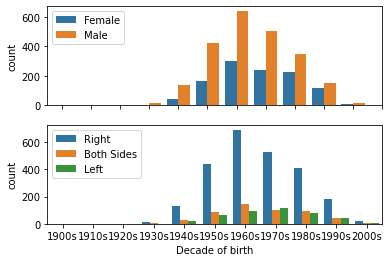

In [5]:
# rename column for legend
bl.rename(columns = {'5': 'Sex', '6':'Handedness'}, inplace = True)

fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
bins = np.arange(1900, 2020, 10)

# draw countplots
sns.countplot(x=pd.cut(bl['4'].dt.year, bins = bins), 
              hue="Sex", data=bl, ax = ax1)
sns.countplot(x=pd.cut(bl['4'].dt.year, bins = bins), 
              hue="Handedness", data=bl, ax = ax2)

# set xlabels
ax1.set(xticks=range(len(bins)), xticklabels=[str(i)+'s' for i in bins])
ax1.set_xlabel('')
ax2.set_xlabel('Decade of birth')

# set legends
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper left')

### Statistics for ages per Sex

In [7]:
filt_male = bl.Sex == 'Male'
bl[filt_male]['4'].dt.year.describe()

count    2267.000000
mean     1970.614027
std        14.930366
min      1901.000000
25%      1960.000000
50%      1969.000000
75%      1980.000000
max      2021.000000
Name: 4, dtype: float64

In [8]:
filt_female = bl.Sex == 'Female'
bl[filt_female]['4'].dt.year.describe()

count    1120.000000
mean     1973.639286
std        14.653528
min      1934.000000
25%      1963.000000
50%      1972.000000
75%      1985.000000
max      2020.000000
Name: 4, dtype: float64